In [66]:
import re
import numpy as np
import pandas as pd
import time
import os
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn import svm 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, precision_recall_curve, average_precision_score 
#from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import operator
from sklearn import metrics
import seaborn as sns
import glob
import openpyxl
from pathlib import Path
from tqdm import tqdm

In [110]:
print("Reading Paths")
feature='RFCC'
train_dataset_real_vsdc = '/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/'+ feature + '/training/0PR/'
train_dataset_spoof_vsdc = '/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/'+ feature + '/training/1PR/'
test_dataset_real_vsdc = '/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/'+ feature +'/testing/0PR/'
test_dataset_spoof_vsdc = '/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/'+ feature +'/testing/1PR/'

train_dataset_path_asv='/scratch/projects/smiles/Multi_Features/Awais_new/'+feature+'/ASVSpoof2019/PA/ASVspoof2019_PA_train/flac/'
eval_dataset_path_asv='/scratch/projects/smiles/Multi_Features/Awais_new/'+feature +'/ASVSpoof2019/PA/ASVspoof2019_PA_eval/flac/'
# dev_dataset_path ='/scratch/projects/smiles/Multi_Features/Awais_new/'+feature +'/ASVSpoof2019/PA/ASVspoof2019_PA_dev/flac/'
train_dataset_load_asv = os.listdir(train_dataset_path_asv) 
train_raw_labels_asv =  open('/scratch/projects/smiles/Multi_Features/Awais_new/ASVspoof2019.PA.cm.train.trn.txt', 'r')
# dev_dataset_load = os.listdir(dev_dataset_path) 
# dev_raw_labels =    open('/scratch/projects/smiles/Multi_Features/Awais_new/ASVspoof2019.PA.cm.dev.trl.txt', 'r')
eval_dataset_load_asv = os.listdir(eval_dataset_path_asv) 
eval_raw_labels_asv =   open('/scratch/projects/smiles/Multi_Features/Awais_new/ASVspoof2019.PA.cm.eval.trl.txt', 'r')


Reading Paths


In [86]:
train_name_r= []
train_names_r= []
train_labels_vsdc= []
train_names= []
train_name_sp = []
n_label_sp = []
n_label_r = []
train_names_sp = []

print('Preparing VSDC Training feature and Labels')

os.chdir("/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/training/0PR/")
for file in sorted(glob.glob("*.xlsx")):
    n_label_r=file.split('.')
    train_name_r=n_label_r[0]
    train_names_r.append(train_name_r)
    
os.chdir("/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/training/1PR/")
for file in sorted(glob.glob("*.xlsx")):
    #print(file)
    n_label_sp=file.split('.')
    train_name_sp=n_label_sp[0]
    train_names_sp.append(train_name_sp)
    
    
print('length of real samples', len(train_names_r))
print('length of spoof samples', len(train_names_sp))

totallength_train = len(train_names_r) + len(train_names_sp)

print(" Creating Feature Space ")
train_features_space_vsdc = np.zeros((totallength_train, 60), dtype='float')
print(train_features_space_vsdc.shape)

print(" Reading & Creating training Features and Labels")

for i in tqdm(range(len(train_names_r))):
    try:
        #print(train_dataset_real+train_names_r[i]+'.xlsx')
        tr_features = pd.read_excel(train_dataset_real_vsdc+train_names_r[i]+'.xlsx', engine='openpyxl', header=None)
        tr_features = tr_features.to_numpy()
        train_features_space_vsdc[i]=tr_features 
        train_labels_vsdc.append(0) # 0=real
    except ValueError:
        print('training real file containing issues: ')
        print(train_dataset_real_vsdc+train_names_r[i]+'.xlsx')
        pass

change_loop = i + 1

print('Total number of training real labels ', len(train_labels_vsdc))


for i in tqdm(range(len(train_names_sp))):
    try:
        #print(train_dataset_spoof+train_names_sp[i]+'.xlsx')
        ts_features = pd.read_excel(train_dataset_spoof_vsdc+train_names_sp[i]+'.xlsx', engine='openpyxl', header=None)
        ts_features = ts_features.to_numpy()
        train_features_space_vsdc[change_loop+i]=ts_features 
        train_labels_vsdc.append(1) # 1=spoof
    except ValueError: 
        print('training spoof file containing issues: ')
        print(train_dataset_spoof_vsdc+train_names_sp[i]+'.xlsx')
        pass

print('Total number of training samples ',len(train_features_space_vsdc))
print('Total number of training labels ', len(train_labels_vsdc))
# print('Training feature shape',train_features_sp.shape)


Preparing VSDC Training feature and Labels
length of real samples 1008
length of spoof samples 3704
 Creating Feature Space 
(4712, 60)
 Reading & Creating training Features and Labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1008/1008 [00:07<00:00, 139.73it/s]


Total number of training real labels  1008


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3704/3704 [00:26<00:00, 137.53it/s]

Total number of training samples  4712
Total number of training labels  4712


In [85]:

print('Preparing VSDC testing features and Labels')

test_name_r= []
test_names_r= []
test_labels_vsdc= []
test_names= []
test_name_sp = []
n_label_sp = []
n_label_r = []
test_names_sp = []

os.chdir("/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/testing/0PR/")
for file in glob.glob("*.xlsx"):
    n_label_r=file.split('.')
    test_name_r=n_label_r[0]
    #print(test_name_r)
    test_names_r.append(test_name_r)

    
os.chdir("/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/testing/1PR/")
for file in glob.glob("*.xlsx"):
    n_label_sp=file.split('.')
    test_name_sp=n_label_sp[0]
    test_names_sp.append(test_name_sp)
    
    
print('length of real samples', len(test_names_r))
print('length of spoof samples', len(test_names_sp))    

totallength_test = len(test_names_r) + len(test_names_sp)


print(" Creating Feature Space ")
test_features_space_vsdc = np.zeros((totallength_test, 60), dtype='float')
print(test_features_space_vsdc.shape)

print(" Reading & Creating training Features and Labels")

for i in tqdm(range(len(test_names_r))):
    try:
        t_features = pd.read_excel(test_dataset_real_vsdc+test_names_r[i]+'.xlsx', engine='openpyxl', header=None)
        t_features = t_features.to_numpy()
        test_features_space_vsdc[i]=t_features 
        test_labels_vsdc.append(0)
    except ValueError:
        print('training real file containing issues: ')
        print(test_dataset_real_vsdc+test_names_r[i]+'.xlsx')
        pass

change_loop1=i+1


for i in tqdm(range(len(test_names_sp))):
    try:
#       len(train_names)
#       print(train_dataset_path+train_names[i]+'.xlsx')
        ts_features = pd.read_excel(test_dataset_spoof_vsdc+test_names_sp[i]+'.xlsx', engine='openpyxl', header=None)
        ts_features = ts_features.to_numpy()
        test_features_space_vsdc[change_loop1+i]=ts_features 
        test_labels_vsdc.append(1)
    except ValueError:
        print('testing spoof file containing  issues: ')
        print(test_dataset_spoof_vsdc+test_names_sp[i]+'.xlsx')
        pass
        
        
print('Total number of Testing VSDC samples ',len(test_features_space_vsdc))
print('Total number of Testing VSDC labels ', len(test_labels_vsdc))


Preparing VSDC testing features and Labels
length of real samples 678
length of spoof samples 2474
 Creating Feature Space 
(3152, 60)
 Reading & Creating training Features and Labels


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2474/2474 [00:17<00:00, 138.60it/s]

Total number of Testing VSDC samples  3152
Total number of Testing VSDC labels  3152


In [111]:
path_train ="/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/training/"
path_test ="/scratch/projects/smiles/Multi_Features/Awais_new_vsdc/VSDC/"+ feature +"/testing/"

In [109]:
print("Saving read features and labels")

np.save(os.path.join(path_train, feature+ '_train_features.npy'), train_features_space_vsdc)
np.save(os.path.join(path_train, feature+ '_train_labels.npy'), train_labels_vsdc)
np.save(os.path.join(path_test, feature+ '_test_features.npy'), test_features_space_vsdc)
np.save(os.path.join(path_test, feature+ '_test_labels.npy'), test_labels_vsdc)

Saving read features and labels


In [112]:
print("Loading read features and labels")
train_features_space_vsdc=list(np.load(os.path.join(path_train, feature + '_train_features.npy'), allow_pickle=True))
train_labels_vsdc=list(np.load(os.path.join(path_train, feature + '_train_labels.npy'), allow_pickle=True))
test_features_space_vsdc=list(np.load(os.path.join(path_test, feature + '_test_features.npy'), allow_pickle=True))
test_labels_vsdc=list(np.load(os.path.join(path_test, feature + '_test_labels.npy'), allow_pickle=True))

Loading read features and labels


In [113]:
print(len(train_features_space_vsdc))
print(len(train_labels_vsdc))
print(len(test_features_space_vsdc))
print(len(test_labels_vsdc))

4712
4712
3152
3152


In [73]:

print('Preparing ASVspoof2019 Data features and labels')
train_names_asv= []
train_labels_asv= []
train_lab = []

eval_names_asv= []
eval_labels_asv= []
eval_lab = []
# dev_names= []
# dev_labels= []

with open('/scratch/projects/smiles/Multi_Features/Awais_new/ASVspoof2019.PA.cm.train.trn.txt', 'r') as f:
    for i,line in enumerate(tqdm(f)): #train_raw_labels
        t_label = line.split(' ')
        t_name = t_label[1]
        #print(i)
        #time.sleep(2)
        train_names_asv.append(t_name.strip())
        t_lab = t_label[4].strip()
        if str(t_lab)=='spoof':
            train_labels_asv.append(1)
        elif str(t_lab)=='bonafide':
            train_labels_asv.append(0)  
print("Done")


with open('/scratch/projects/smiles/Multi_Features/Awais_new/ASVspoof2019.PA.cm.eval.trl.txt', 'r') as f:
    for j,line1 in enumerate(tqdm(f)): #train_raw_labels
        e_label = line1.split(' ')
        e_name = e_label[1]
        #print(i)
        #time.sleep(2)
        eval_names_asv.append(e_name.strip())
        eval_lab = e_label[4].strip()
        if str(eval_lab)=='spoof':
            eval_labels_asv.append(1)
        elif str(eval_lab)=='bonafide':
            eval_labels_asv.append(0)  
print("Done")



# print(" Preparing Development Data ")  
# for j in dev_raw_labels:
#     d_label = j.split(' ')
#     d_name = d_label[1]
#     dev_names_asv.append(d_name.strip())
#     dev_lab = d_label[4].strip()
#     if str(dev_lab)=='spoof':
#         dev_labels_asv.append(0)
#     elif str(dev_lab)=='bonafide':
#         dev_labels_asv.append(1)  
  
print(" Reading & Creating Features ")

train_features_space_asv = np.zeros((len(train_names_asv), 60), dtype='float')
print(train_features_space_asv.shape)

eval_features_space_asv = np.zeros((len(eval_names_asv), 60), dtype='float')
print(eval_features_space_asv.shape)

# dev_features_space_asv = np.zeros((len(dev_names_asv), 60), dtype='float')
# print(dev_features_space_asv.shape)

 
for i in tqdm(range(len(train_names_asv))): #len(names)
    try:
        t_features = pd.read_excel(train_dataset_path_asv+train_names_asv[i]+'.xlsx', engine='openpyxl', header=None)
        t_features = t_features.to_numpy()
        train_features_space_asv[i]=t_features
    except ValueError:
        print('training real file containing issues: ')
        print(train_dataset_path_asv+train_names_asv[i]+'.xlsx')
        pass

for k in tqdm(range(len(eval_names_asv))): #len(names)
    try:
        e_features = pd.read_excel(eval_dataset_path_asv+eval_names_asv[k]+'.xlsx', engine='openpyxl', header=None)
        e_features = e_features.to_numpy()
        eval_features_space_asv[k]=e_features 
    except ValueError:
        print('training real file containing issues: ')
        print(eval_dataset_path_asv+eval_names_asv[k]+'.xlsx')
        pass
    
# for j in range(len(dev_names)): #len(names)
#     d_features = pd.read_excel(dev_dataset_path_asv+dev_names_asv[j]+'.xlsx', engine='openpyxl', header=None)
#     d_features = d_features.to_numpy()
#     dev_features_space_asv[j]=d_features 

    

Preparing ASVspoof2019 Data features and labels


54000it [00:00, 864072.52it/s]


Done


134730it [00:00, 653488.07it/s]


Done
 Reading & Creating Features 
(54000, 60)
(134730, 60)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 134730/134730 [36:46<00:00, 61.06it/s]


In [115]:
path='/scratch/projects/smiles/Multi_Features/Awais_new/'+feature+'/ASVSpoof2019/PA/ASVspoof2019_PA_train/'

In [116]:
print("Saving read features and labels")

np.save(os.path.join(path, feature+ '_training.npy'), train_features_space_asv)
np.save(os.path.join(path, feature+ '_evaluation.npy'), eval_features_space_asv)
np.save(os.path.join(path, feature+ '_train_labels.npy'), train_labels_asv)
np.save(os.path.join(path, feature+ '_eval_labels.npy'), eval_labels_asv)

Saving read features and labels


In [117]:
print("Loading read features and labels")
train_features_space_asv=list(np.load(os.path.join(path, feature+ '_training.npy'), allow_pickle=True))
train_labels_asv=list(np.load(os.path.join(path, feature + '_train_labels.npy'), allow_pickle=True))
test_features_space_asv=list(np.load(os.path.join(path, feature + '_evaluation.npy'), allow_pickle=True))
test_labels_asv=list(np.load(os.path.join(path, feature+ '_eval_labels.npy'), allow_pickle=True))

Loading read features and labels


In [118]:
count_train_zero = train_labels_asv.count(0)
count_train_ones = train_labels_asv.count(1)
print("Training Sample -> Total:", count_train_zero+count_train_ones, "Spoof:", count_train_ones, "Bonafide:",count_train_zero)
count_eval_zero = eval_labels_asv.count(0)
count_eval_ones = eval_labels_asv.count(1)
print("Development Sample -> Total:", count_eval_zero+count_eval_ones, "Spoof:", count_eval_ones, "Bonafide:",count_eval_zero)

Training Sample -> Total: 54000 Spoof: 48600 Bonafide: 5400
Development Sample -> Total: 134730 Spoof: 116640 Bonafide: 18090


In [101]:
training_labels_vsdc = np.array(train_labels_vsdc)
Evaluation_labels_vsdc = np.array(test_labels_vsdc)
training_features_vsdc = np.array(train_features_space_vsdc)
Evaluation_features_vsdc = np.array(test_features_space_vsdc)
print('VSDC Training Labels '  , training_labels_vsdc.shape)
print('VSDC Training Features ', training_features_vsdc.shape)
print('VSDC Testing Labels '   , Evaluation_labels_vsdc.shape)
print('VSDC Testing Features ' , Evaluation_features_vsdc.shape)
print("setting VSDC train test Data")
#X_train, X_test, y_train, y_test = train_test_split(train_features_space, train_labels, train_size = 0.70)
X_train_vsdc=training_features_vsdc
X_test_vsdc=Evaluation_features_vsdc
y_train_vsdc=training_labels_vsdc
y_test_vsdc=Evaluation_labels_vsdc


training_labels_asv = np.array(train_labels_asv)
Evaluation_labels_asv = np.array(eval_labels_asv)
training_features_asv = np.array(train_features_space_asv)
Evaluation_features_asv = np.array(eval_features_space_asv)
print('ASV Training Labels ', training_labels_asv.shape)
print('ASV Training Features ', training_features_asv.shape)
print('ASV Evaluation Labels ' , Evaluation_labels_asv.shape)
print('ASV Evaluation Features ',Evaluation_features_asv.shape)
print("setting ASV train test Data")
#X_train, X_test, y_train, y_test = train_test_split(train_features_space, train_labels, train_size = 0.70)
X_train_asv=training_features_asv
X_test_asv=Evaluation_features_asv
y_train_asv=training_labels_asv
y_test_asv=Evaluation_labels_asv



VSDC Training Labels  (4712,)
VSDC Training Features  (4712, 60)
VSDC Testing Labels  (3152,)
VSDC Testing Features  (3152, 60)
setting VSDC train test Data
ASV Training Labels  (54000,)
ASV Training Features  (54000, 60)
ASV Evaluation Labels  (134730,)
ASV Evaluation Features  (134730, 60)
setting ASV train test Data


In [119]:
print('Classifier Setting')
model_svm = SVC(kernel="rbf",probability=True)
model_svm.fit(X_train_vsdc, y_train_vsdc)


Classifier Setting


SVC(probability=True)

In [120]:
y_pred_svm = model_svm.predict(X_test_asv)

Computing Results

Confusion Matrix: 
 [[     0  18090]
 [     0 116640]]

Confusion Matrix: 
 [[     0  18090]
 [     0 116640]]
classification Report


/home/a/awaiskhan/.conda/envs/deepspeak/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a/awaiskhan/.conda/envs/deepspeak/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/a/awaiskhan/.conda/envs/deepspeak/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     18090
           1       0.87      1.00      0.93    116640

    accuracy                           0.87    134730
   macro avg       0.43      0.50      0.46    134730
weighted avg       0.75      0.87      0.80    134730

classification Report END
Hand-crafted Features:  APGDF
Score Report Start
EER: 0.0
accuracy: 0.8657314629258517
precision: [0.         0.86573146]
recall: [0. 1.]
fscore: [0.         0.92803437]
support: [ 18090 116640]
Score Report End


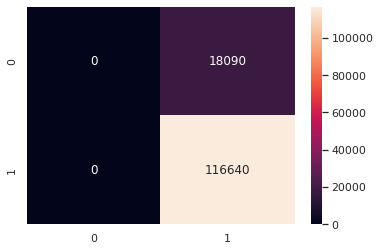

In [121]:
print('Computing Results')

sns.set(font_scale=1.0)
conf_mtx_nb_svm = metrics.confusion_matrix(y_test_asv, y_pred_svm)
sns.heatmap(conf_mtx_nb_svm, annot=True, fmt='g')
print('\nConfusion Matrix: \n', conf_mtx_nb_svm )

sns.set(font_scale=1.0)
conf_mtx_nb_svm = metrics.confusion_matrix(y_test_asv, y_pred_svm)
#sns.heatmap(conf_mtx_nb_svm, annot=True, fmt='g')
print('\nConfusion Matrix: \n', conf_mtx_nb_svm )


print('classification Report')
report=classification_report(y_test_asv, y_pred_svm)
print(report)

accuracy=accuracy_score(y_test_asv, y_pred_svm)
precision, recall, fscore, support = score(y_test_asv, y_pred_svm)
print('classification Report END')

fpr, tpr, threshold = roc_curve(y_test_asv, y_pred_svm)
fnr = 1 - tpr
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
EER = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

print('Hand-crafted Features: ',feature)
print('Score Report Start')
print('EER: {}'.format(EER))
print('accuracy: {}'.format(accuracy))
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print('Score Report End')
